In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import Circle
import cv2

In [56]:
def rigid_transform_3D(A, B):
    assert A.shape == B.shape

    num_rows, num_cols = A.shape
    if num_rows != 3:
        raise Exception(f"matrix A is not 3xN, it is {num_rows}x{num_cols}")

    num_rows, num_cols = B.shape
    if num_rows != 3:
        raise Exception(f"matrix B is not 3xN, it is {num_rows}x{num_cols}")

    # find mean column wise
    centroid_A = np.mean(A, axis=1)
    centroid_B = np.mean(B, axis=1)

    # ensure centroids are 3x1
    centroid_A = centroid_A.reshape(-1, 1)
    centroid_B = centroid_B.reshape(-1, 1)

    # subtract mean
    Am = A - centroid_A
    Bm = B - centroid_B

    H = Am @ np.transpose(Bm)

    # sanity check
    #if linalg.matrix_rank(H) < 3:
    #    raise ValueError("rank of H = {}, expecting 3".format(linalg.matrix_rank(H)))

    # find rotation
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T

    # special reflection case
    if np.linalg.det(R) < 0:
        print("det(R) < R, reflection detected!, correcting for it ...")
        Vt[2,:] *= -1
        R = Vt.T @ U.T

    t = -R @ centroid_A + centroid_B

    return R, t

In [57]:
# meta porta corridoio lavagne fine: 0870
# porta anti incendio corridoio per andare verso il corridoio delle lavagne: 0538
# spigolo per girare a sinistra verso tavoloni 1366

# 632 centro angolo lavagne

In [58]:
positions = pd.read_csv('../data/povo-god/positions.csv')
predictions = pd.read_csv('../data/povo-god/predictions.csv')
targets = pd.read_csv('../data/povo-god/targets.csv')
A = '0538.png'
B = '0870.png'
C = '1366.png'

In [59]:
px = 630
a = positions[positions.image == '0632.png'][['x','y','z']].squeeze()
b = positions[positions.image == '0891.png'][['x','y','z']].squeeze()
unit_measure = np.sqrt(np.sum((a - b)**2))
unit_measure

4.22608635945641

In [60]:
colmap_crs = positions[positions.image.isin([A, B, C])][['x','y','z']].values.T
cadatastral_crs = np.array([
    [690, 430, 1715],
    [280, 895, 1050],
    [0, 0, 0]
])
colmap_crs = colmap_crs / unit_measure * px

In [61]:
# RA + t = B
R, t = rigid_transform_3D(colmap_crs, cadatastral_crs)
R, t

(array([[ 0.09043424,  0.21994528, -0.97131134],
        [-0.99584784,  0.00975923, -0.09050882],
        [-0.01042773,  0.97546339,  0.2199146 ]]),
 array([[1080.31885417],
        [ 652.52917988],
        [  -1.84188703]]))

In [62]:
#points = positions[positions.image.isin(['0554.png', '0001.png', '0999.png'])][['x','y','z']].values.T
points = positions[['x','y','z']].values.T
points = points / unit_measure * px

predictions = predictions[['tx','ty','tz']].values.T
predictions = predictions / unit_measure * px

targets = targets[['tx','ty','tz']].values.T
targets = targets / unit_measure * px

D = (np.matmul(R, points) + t).T
F = (np.matmul(R, predictions) + t).T
G = (np.matmul(R, targets) + t).T

# Trajectory map

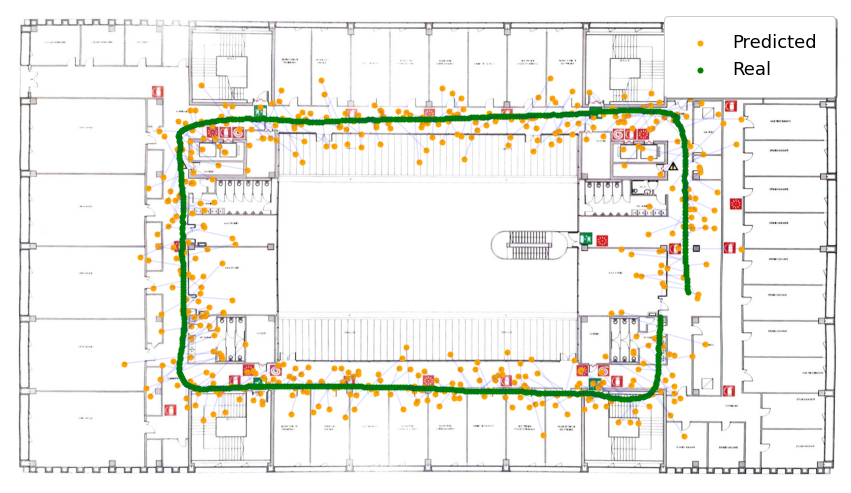

In [63]:
img = plt.imread('../camera-pose-estimation/model/static/cadatastral_plan_all.jpg')
fig, ax = plt.subplots(1, figsize=(15,15))
ax.set_aspect('equal')
ax.axis('off')

ax.imshow(img)
ax.scatter(F[:, 0], F[:, 1], s=25, c='orange', label='Predicted')
ax.scatter(G[:, 0], G[:, 1], s=25, c='green', label='Real')
#ax.scatter(G[:, 0], G[:, 1]*0.95+15, s=25, c='green', label='Real')    

for a,b in zip(F, G):
    ax.plot([a[0],b[0]],[a[1],b[1]], color='blue', alpha=0.1)

#ax.legend(['a','b', 'c'], scatterpoints=1, loc='upper right', fancybox=True, framealpha=1, shadow=True, borderpad=1)
ax.legend(
    loc='upper right',
    fancybox=True,
    framealpha=1,
    shadow=True,
    borderpad=1,
    prop={'size': 18}
)
fig.savefig('../net_weights/posenet_map.png', dpi=100)
plt.show()

# Error computation (m)
89px:233cm (cadatastral_plan_all.jpg, wall between snack machines and bathroom)

In [64]:
def euclidean_distance(p1, p2):
    return np.sqrt((p1[0] - p2[0])**2+(p1[1] - p2[1])**2)
def pixel_to_meter(pixel_value):
    return (233/89)*pixel_value

In [65]:
distances = []
for p1, p2 in zip(F,G):
    distances.append(
        pixel_to_meter(euclidean_distance(p1,p2))
    )
distances = np.array(distances)
distances.mean()

153.30483422630115

# Walkable area map

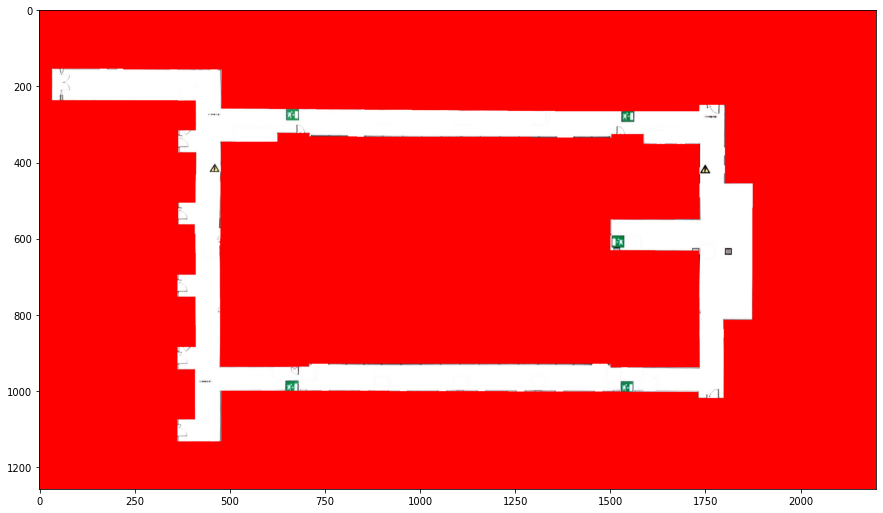

In [26]:
img = plt.imread('../camera-pose-estimation/model/static/cadatastral_plan_all_walkable.jpg')
fig, ax = plt.subplots(1, figsize=(15,15))

ax.imshow(img)

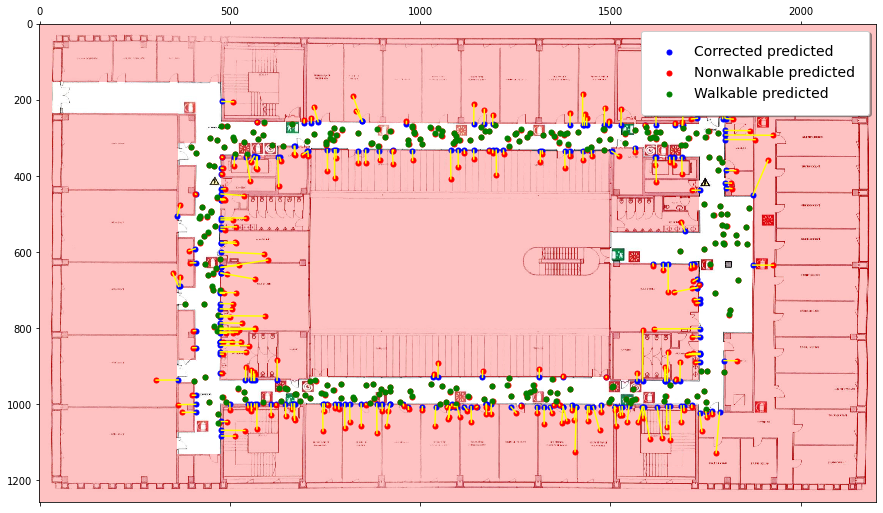

In [27]:
F2 = []
img=cv2.imread('../camera-pose-estimation/model/static/cadatastral_plan_all_walkable.jpg')
alpha = plt.imread('../camera-pose-estimation/model/static/cadatastral_plan_all_alpha.jpg')

img_hsv=cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

lower_red = np.array([0,50,50])
upper_red = np.array([10,255,255])
mask0 = cv2.inRange(img_hsv, lower_red, upper_red)
is_walkable = mask0!=255
fig, ax = plt.subplots(1, figsize=(15,15))


predetto = F[300]
ax.matshow(alpha)

def adjust_prediction(prediction):
    x, y = prediction.astype(int)[:2]
    if is_walkable[y, x]:
        return Circle((x, y), 7, color='green'), x, y, True
    min_dist, min_row, min_col = (np.Inf,0,0)
    for i_row, row in enumerate(is_walkable):
        for i_col, cell in enumerate(row):
            if cell:
                dist = np.sqrt((y - i_row)**2+(x - i_col)**2)
                if dist < min_dist:
                    min_dist = dist
                    min_row = i_row
                    min_col = i_col
    return Circle((min_col, min_row), 7, color='red'), min_col, min_row, False

uno = []
due = []
tre = []

for p in F[:]: 
    circ2 = Circle((p[0], p[1]), 7, color='blue')
    tre.append([p[0], p[1]])
    #ax.add_patch(circ2)
    circ, x, y, walkable = adjust_prediction(p)
    #ax.add_patch(circ)
    if not walkable:
        uno.append([x, y])
        F2.append([x, y])
        ax.plot([x, p[0]], [y, p[1]], color='yellow')
    else:
        due.append([x, y])
        F2.append([x, y])
        
uno = np.array(uno)
due = np.array(due)
tre = np.array(tre)

ax.scatter(uno[:, 0], uno[:, 1], s=25, c='blue', label='Corrected predicted')
ax.scatter(tre[:, 0], tre[:, 1], s=25, c='red', label='Nonwalkable predicted')
ax.scatter(due[:, 0], due[:, 1], s=25, c='green', label='Walkable predicted')
        
ax.legend(
    loc='upper right',
    fancybox=True,
    framealpha=1,
    shadow=True,
    borderpad=1,
    prop={'size': 14}
)

fig.savefig('../net_weights/walkable-postprocess.png', dpi=100)

# Error computation (m)
89px:233cm (cadatastral_plan_all.jpg, wall between snack machines and bathroom)

In [28]:
distances = []
for p1, p2 in zip(F2,G):
    distances.append(
        pixel_to_meter(euclidean_distance(p1,p2))
    )
distances = np.array(distances)
distances.mean()

130.90922966262198

# PoseNet MapNet comparison

In [66]:
positions = pd.read_csv('../data/povo-god/positions.csv')
predictions = pd.read_csv('../data/povo-god/predictions.csv')
predictions_posenet = pd.read_csv('../data/povo-god/predictions_posenet.csv')
targets = pd.read_csv('../data/povo-god/targets.csv')
A = '0538.png'
B = '0870.png'
C = '1366.png'

In [67]:
px = 630
a = positions[positions.image == '0632.png'][['x','y','z']].squeeze()
b = positions[positions.image == '0891.png'][['x','y','z']].squeeze()
unit_measure = np.sqrt(np.sum((a - b)**2))
unit_measure

4.22608635945641

In [68]:
colmap_crs = positions[positions.image.isin([A, B, C])][['x','y','z']].values.T
cadatastral_crs = np.array([
    [690, 430, 1715],
    [280, 895, 1050],
    [0, 0, 0]
])
colmap_crs = colmap_crs / unit_measure * px

In [69]:
# RA + t = B
R, t = rigid_transform_3D(colmap_crs, cadatastral_crs)
R, t

(array([[ 0.09043424,  0.21994528, -0.97131134],
        [-0.99584784,  0.00975923, -0.09050882],
        [-0.01042773,  0.97546339,  0.2199146 ]]),
 array([[1080.31885417],
        [ 652.52917988],
        [  -1.84188703]]))

In [70]:
#points = positions[positions.image.isin(['0554.png', '0001.png', '0999.png'])][['x','y','z']].values.T
points = positions[['x','y','z']].values.T
points = points / unit_measure * px

predictions = predictions[['tx','ty','tz']].values.T
predictions = predictions / unit_measure * px
predictions_posenet = predictions_posenet[['tx','ty','tz']].values.T
predictions_posenet = predictions_posenet / unit_measure * px

targets = targets[['tx','ty','tz']].values.T
targets = targets / unit_measure * px

D = (np.matmul(R, points) + t).T
F = (np.matmul(R, predictions) + t).T
G = (np.matmul(R, targets) + t).T
H = (np.matmul(R, predictions_posenet) + t).T

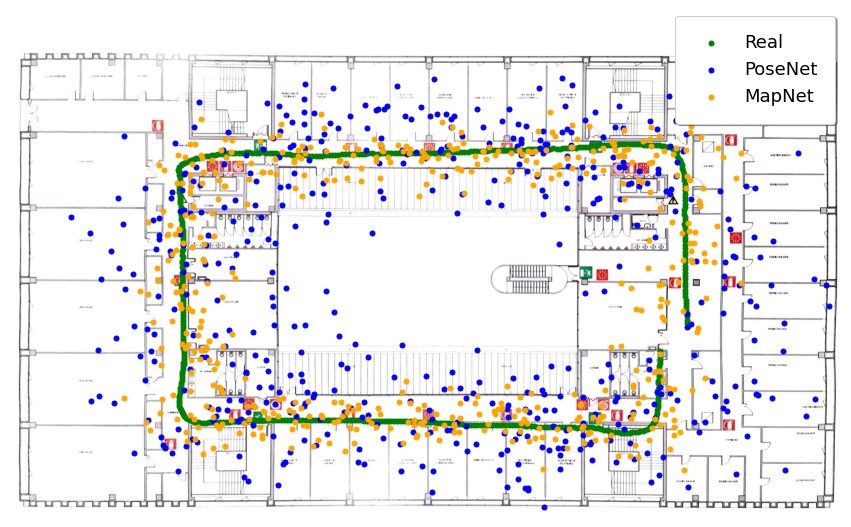

In [71]:
img = plt.imread('../camera-pose-estimation/model/static/cadatastral_plan_all.jpg')
fig, ax = plt.subplots(1, figsize=(15,15))
ax.set_aspect('equal')
ax.axis('off')

ax.imshow(img)
ax.scatter(G[:, 0], G[:, 1], s=25, c='green', label='Real')
ax.scatter(H[:, 0], H[:, 1], s=25, c='blue', label='PoseNet')
ax.scatter(F[:, 0], F[:, 1], s=25, c='orange', label='MapNet')
#ax.scatter(G[:, 0], G[:, 1]*0.95+15, s=25, c='green', label='Real')    

#ax.legend(['a','b', 'c'], scatterpoints=1, loc='upper right', fancybox=True, framealpha=1, shadow=True, borderpad=1)
ax.legend(
    loc='upper right',
    fancybox=True,
    framealpha=1,
    shadow=True,
    borderpad=1,
    prop={'size': 18}
)
fig.savefig('../net_weights/posenet_map.png', dpi=100)
plt.show()

# Error computation (m)
89px:233cm (cadatastral_plan_all.jpg, wall between snack machines and bathroom)

In [72]:
def euclidean_distance(p1, p2):
    return np.sqrt((p1[0] - p2[0])**2+(p1[1] - p2[1])**2)
def pixel_to_meter(pixel_value):
    return (233/89)*pixel_value

In [80]:
distances = []
for p1, p2 in zip(H,G):
    distances.append(
        pixel_to_meter(euclidean_distance(p1,p2))
    )
distances = np.array(distances)
distances.mean()

2000.1704681488313